# FAD Project: Steam Games 2025 Dataset Analysis
## Questions:
1. What is the relationship between the review score and the Metacritic rating?
    (i.e., the correlation between user reviews and critics’ reviews)
2. Which genres achieve the highest review scores?
3. Which developers produce games with the most consistent review scores?
## Techniques used: 
1. Correlation analysis (Pearson and Spearman) and linear regression. Extra visualization with box plots and violin plots due to the non-linear relationship. 
2. Descriptive statistics: mean, median, standard deviation, and variance: visualized with box plots.
3. Calculation of variability indices (standard deviation, range, and coefficient of variation) to measure score consistency for each developer; optionally, clustering to identify common patterns.

# 1. Cleaning the data:

## 1.1 Helper functions

In [1]:
def print_filter_stats(in_df, step_name):
    """
    Print the number of rows in a DataFrame at each filtering step.

    Args:
        in_df: The pandas DataFrame to analyze
        step_name: A string describing the current filtering step

    Returns:
        The original DataFrame (to allow chaining)
    """
    print(f"Step: {step_name} - Rows remaining: {len(in_df):,} ({len(in_df)/initial_rows:.2%})")
    return in_df


In [2]:
def convert_date(date_str):
    try:
        # Try multiple date formats
        for fmt in ['%Y-%m-%d', '%b %d, %Y', '%B %d, %Y', '%Y']:
            try:
                return pd.to_datetime(date_str, format=fmt)
            except:
                continue
        return pd.to_datetime(date_str)
    except:
        return pd.NaT

## 1.2 Load and clean the dataset

In [3]:
import pandas as pd
from datetime import datetime

# Load the dataset
df = pd.read_csv('src/steam_games.csv')

# Inspect raw data format
print("Raw dataset overview:")
print(df.info(memory_usage="deep"))
print("\nSample of raw release_date values:")
print(df['release_date'].head(10))
print("\nUnique release_date formats:", df['release_date'].unique()[:10])

# Convert release_date to datetime, handling multiple formats
df['release_date'] = df['release_date'].apply(convert_date)

# Convert scores to numeric, printing unique values before conversion
print("\nUnique review_score values (sorted):", sorted([float(x) for x in df['review_score'].unique()]))
print("Unique metacritic values (sorted):", sorted([int(x) for x in df['metacritic'].unique()]))

df['review_score'] = pd.to_numeric(df['review_score'], errors='coerce')
df['metacritic'] = pd.to_numeric(df['metacritic'], errors='coerce')

# Filter data
today = pd.Timestamp(datetime.now())
initial_count = len(df)

# Start with the original dataframe
filtered_df = df.copy()
initial_rows = len(filtered_df)

# Step 1: Track the initial state
print_filter_stats(filtered_df, "1 - initial load")

# Step 2: Keep only released titles
filtered_df = filtered_df[filtered_df['is_released']]
print_filter_stats(filtered_df, "2 - released games filter")

# Step 3: Keep games with valid release dates before today
release_date_mask = filtered_df['release_date'].notna() & (filtered_df['release_date'] <= today)
filtered_df = filtered_df[release_date_mask]
print_filter_stats(filtered_df, "3 - release date filter")

# Step 4: Keep rows with valid scores (more permissive)
filtered_df = filtered_df.dropna(subset=['review_score', 'metacritic'], how='all')
print_filter_stats(filtered_df, "4 - score availability filter")

# Step 5: Keep games with at least one valid score > 0
score_mask = (filtered_df['review_score'] > 0) | (filtered_df['metacritic'] > 0)
filtered_df = filtered_df[score_mask]
print_filter_stats(filtered_df, "5 - positive score filter")

# Step 6: Remove duplicates
clean = filtered_df.drop_duplicates(subset='steam_appid')
print_filter_stats(clean, "6 - duplicate removal")


# Final dataset statistics
print("\nFinal cleaned dataset statistics:")
print("\nScore statistics:")
print(clean[['review_score', 'metacritic']].describe())

print("\nMissing values in final dataset:")
print(clean[['review_score', 'metacritic', 'release_date']].isna().sum())

# Save the cleaned dataset
clean.to_csv('src/steam_games_cleaned.csv', index=False)

# Display sample of the cleaned dataset
print("\nSample of cleaned dataset:")
print(clean.head())


Raw dataset overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71429 entries, 0 to 71428
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   steam_appid          71429 non-null  int64  
 1   name                 71429 non-null  object 
 2   developers           71429 non-null  object 
 3   publishers           71429 non-null  object 
 4   categories           71429 non-null  object 
 5   genres               71429 non-null  object 
 6   required_age         71429 non-null  int64  
 7   n_achievements       71429 non-null  int64  
 8   platforms            71429 non-null  object 
 9   is_released          71429 non-null  bool   
 10  release_date         71429 non-null  object 
 11  additional_content   71429 non-null  object 
 12  total_reviews        71429 non-null  int64  
 13  total_positive       71429 non-null  int64  
 14  total_negative       71429 non-null  int64  
 15  review_score  

# 2. Analysis Tasks:

## 2.1 Relationship between review score and Metacritic rating

Number of games with both review score and Metacritic rating: 24026

Correlation Analysis:
Pearson correlation: 0.1164 (p-value: 3.21e-73)
Spearman correlation: 0.1249 (p-value: 4.54e-84)


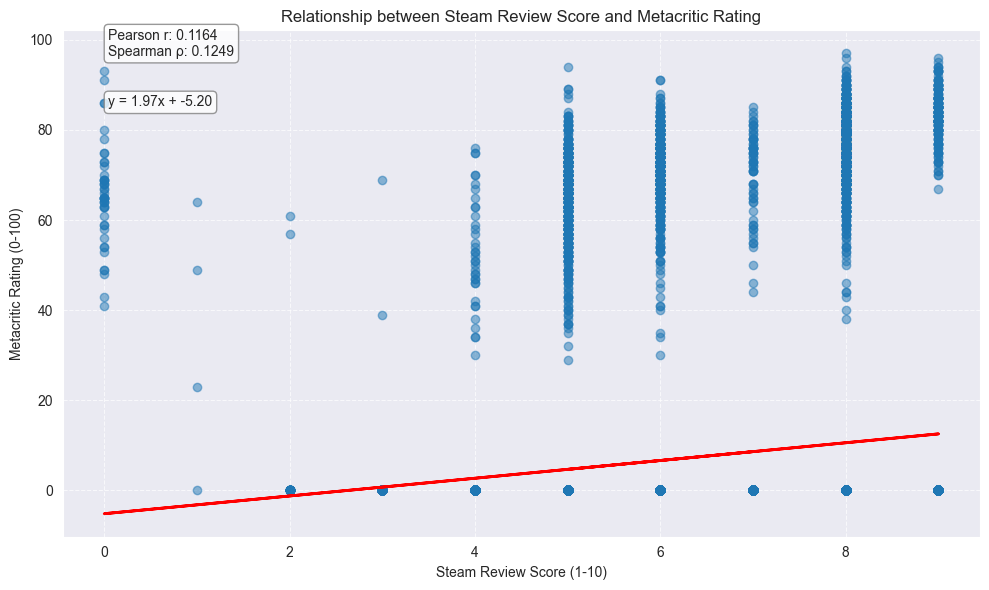


Linear Regression Results:
Slope (coefficient): 1.9689
Intercept: -5.1987
R² score: 0.0135


In [4]:
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.linear_model import LinearRegression

# Filter out rows where either review_score or metacritic is missing
score_df = clean.dropna(subset=['review_score', 'metacritic'])

# Print the number of games with both scores available
print(f"Number of games with both review score and Metacritic rating: {len(score_df)}")

# Calculate correlations
pearson_corr, pearson_p = stats.pearsonr(score_df['review_score'], score_df['metacritic'])
spearman_corr, spearman_p = stats.spearmanr(score_df['review_score'], score_df['metacritic'])

print(f"\nCorrelation Analysis:")
print(f"Pearson correlation: {pearson_corr:.4f} (p-value: {pearson_p:.2e})")
print(f"Spearman correlation: {spearman_corr:.4f} (p-value: {spearman_p:.2e})")

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(score_df['review_score'], score_df['metacritic'], alpha=0.5)
plt.title('Relationship between Steam Review Score and Metacritic Rating')
plt.xlabel('Steam Review Score (1-10)')
plt.ylabel('Metacritic Rating (0-100)')
plt.grid(True, linestyle='--', alpha=0.7)

# Add linear regression line
X = score_df['review_score'].values.reshape(-1, 1)
y = score_df['metacritic'].values
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
plt.plot(score_df['review_score'], y_pred, color='red', linewidth=2)

# Add correlation information to the plot
plt.annotate(f"Pearson r: {pearson_corr:.4f}\nSpearman ρ: {spearman_corr:.4f}",
             xy=(0.05, 0.95), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Add regression equation
slope = model.coef_[0]
intercept = model.intercept_
plt.annotate(f"y = {slope:.2f}x + {intercept:.2f}",
             xy=(0.05, 0.85), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.show()

# Print regression results
print(f"\nLinear Regression Results:")
print(f"Slope (coefficient): {slope:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"R² score: {model.score(X, y):.4f}")


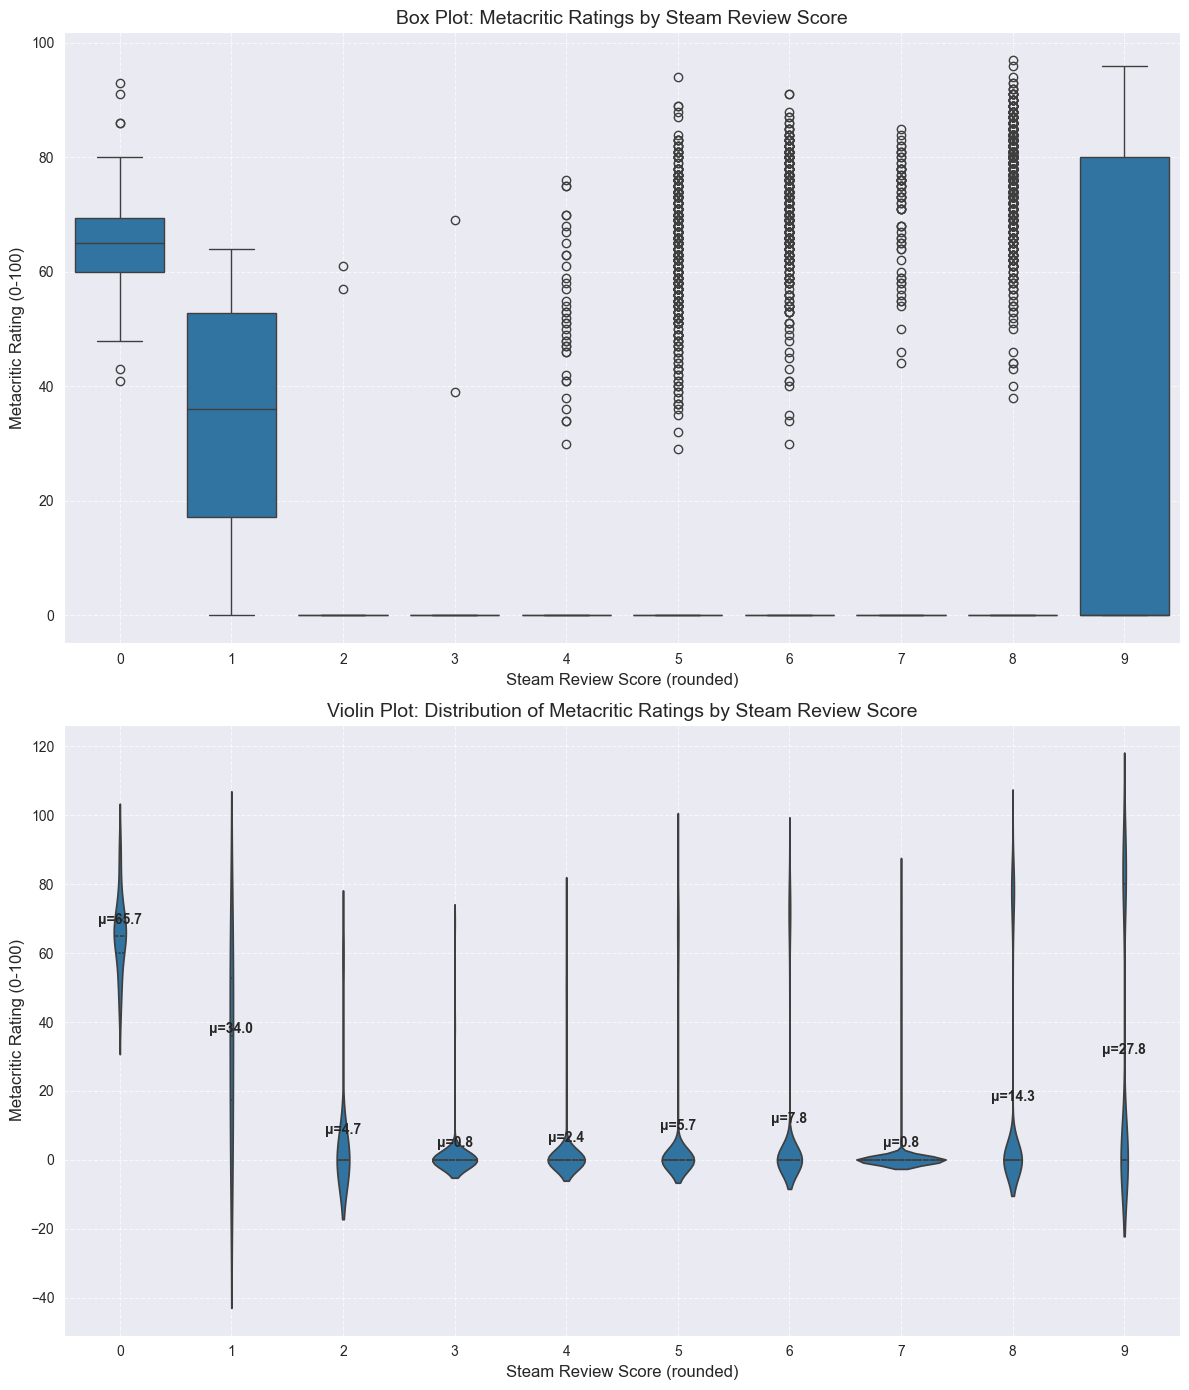


Summary Statistics by Review Score Group:
                      count       mean        std  min  median  max
review_score_rounded                                               
0                        47  65.680851  11.127925   41    65.0   93
1                         4  34.000000  28.296054    0    36.0   64
2                        25   4.720000  16.346559    0     0.0   61
3                       133   0.812030   6.850293    0     0.0   69
4                       806   2.447891  11.463651    0     0.0   76
5                      5730   5.744852  18.614803    0     0.0   94
6                      4224   7.750947  22.260699    0     0.0   91
7                      6076   0.766129   7.378968    0     0.0   85
8                      6399  14.307704  30.059910    0     0.0   97
9                       582  27.836770  39.524356    0     0.0   96


In [5]:
# Additional visualization using Box Plots and Violin Plots
import seaborn as sns

# Round review scores to the nearest integer for grouping
score_df['review_score_rounded'] = score_df['review_score'].round().astype(int)

# Create a figure with two subplots (box plot and violin plot)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 14))

# Box plot
sns.boxplot(x='review_score_rounded', y='metacritic', data=score_df, ax=ax1)
ax1.set_title('Box Plot: Metacritic Ratings by Steam Review Score', fontsize=14)
ax1.set_xlabel('Steam Review Score (rounded)', fontsize=12)
ax1.set_ylabel('Metacritic Rating (0-100)', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.7)

# Add median values as text annotations
for i, box in enumerate(ax1.artists):
    score_group = i + min(score_df['review_score_rounded'])
    median = score_df[score_df['review_score_rounded'] == score_group]['metacritic'].median()
    ax1.text(i, median + 2, f'{median:.1f}', ha='center', va='bottom', fontweight='bold')

# Violin plot
sns.violinplot(x='review_score_rounded', y='metacritic', data=score_df, ax=ax2, inner='quartile')
ax2.set_title('Violin Plot: Distribution of Metacritic Ratings by Steam Review Score', fontsize=14)
ax2.set_xlabel('Steam Review Score (rounded)', fontsize=12)
ax2.set_ylabel('Metacritic Rating (0-100)', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.7)

# Add mean values as text annotations
for i, score in enumerate(sorted(score_df['review_score_rounded'].unique())):
    mean_value = score_df[score_df['review_score_rounded'] == score]['metacritic'].mean()
    ax2.text(i, mean_value + 2, f'μ={mean_value:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary statistics for each review score group
print("\nSummary Statistics by Review Score Group:")
summary_stats = score_df.groupby('review_score_rounded')['metacritic'].agg(['count', 'mean', 'std', 'min', 'median', 'max'])
print(summary_stats)


### 2.1.1 Box Plot and Violin Plot Analysis

The box plots and violin plots provide additional insights into the relationship between Steam review scores and Metacritic ratings:

- **Non-linear relationship**: The box plots show that the median Metacritic rating generally increases with higher Steam review scores, but not in a perfectly linear fashion. This suggests a more complex relationship than what the linear regression captured.

- **Variability across scores**: The box plots reveal substantial variability in Metacritic ratings within each Steam review score category. Even games with high Steam scores (8-10) show a wide range of Metacritic ratings, from very low to very high.

- **Distribution shapes**: The violin plots show that the distribution of Metacritic ratings varies across different Steam review scores. Some score categories have more uniform distributions, while others show multi-modal patterns or skewness.

- **Outliers**: Both plots highlight outliers, particularly for games with lower Steam review scores that nonetheless received high Metacritic ratings, and vice versa.

- **Median vs. Mean differences**: Comparing the median values (box plots) with the mean values (violin plots) reveals some asymmetry in the distributions, with means sometimes being pulled higher or lower than medians due to outliers.

These visualizations suggest that while there is a weak positive correlation between Steam user reviews and Metacritic ratings, the relationship is more nuanced than a simple linear correlation. The overlap in Metacritic ratings across different Steam score categories further explains the low R² value observed in the regression analysis.


### 2.1.2 Summary of Findings

- **Dataset size:** After filtering out missing values, the analysis uses **24026** games with both a Steam user review score (1–10) and a Metacritic critic rating (0–100).

<br>

- **Correlation analysis:**
  - **Pearson correlation** $(r = 0.1164), (p≈3.21×10^{-73})$
  - **Spearman rank correlation** $(rho = 0.1249), (p≈4.54×10^{-84})$
  - _Interpretation:_ Both tests are “statistically significant” only because of the large sample size; the effect sizes (|r|, |ρ| ≈ 0.12) remain very small.

<br>

- **Linear regression (OLS):**  
$$
    {\text{Metacritic}} = 1.9689 \times (\text{Steam score}) \;-\; 5.1987
$$
    - **Dependant variable**: Metacritic rating (0–100)
    - **Independent variable**: Steam review score (1–10)
    - **Coefficient (slope):** 1.9689  
    - **Intercept:** −5.1987  
    - **R² (variance explained):** 0.0135 (≈1.35% of Metacritic variance)

<br>

- **Key conclusion:**  
  - There is a **very weak** positive association between Steam user scores and Metacritic critic ratings.  
  - The slope is shallow and the scatterplot shows wide variability at every Steam score.  
  - **Practical significance** is minimal: you **cannot** reliably predict a game’s Metacritic rating from its Steam review score, despite the statistically “significant” p‑values.

<br>

- **Notes on p‑values:**  
    - The p-values are both extremely small, indicating that the null hypothesis (no correlation) can be rejected.
    - Focus on the **effect size** (r, $R^2$) rather than the p‑value for practical interpretation. It indicates that the correlation is weak, even if statistically significant.

<br>

- **Box plots and violin plots analysis:**
    - **Non-linear relationship**: The median Metacritic rating generally increases with higher Steam review scores, but not in a perfectly linear fashion.
    - **High variability**: Substantial variability exists in Metacritic ratings within each Steam review score category, with even high-scoring games (8-10) showing ratings from very low to very high.
    - **Distribution differences**: The distribution shapes vary across different Steam review scores, with some showing uniform distributions and others displaying multi-modal patterns or skewness.
    - **Presence of outliers**: Games with lower Steam review scores can receive high Metacritic ratings, and vice versa.
    - **Distribution asymmetry**: Differences between median and mean values indicate asymmetric distributions in several score categories.
